In [3]:
import requests

url = "https://raw.githubusercontent.com/dthomas1108/year4-data-visualisation-assignment/refs/heads/master/collision2017.csv"
r = requests.get(url)

with open("file.csv", "wb") as f:
    f.write(r.content)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
from dash import Dash, dcc, html, Input, Output, ctx
import plotly.express as px
import webview
from threading import Thread
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
import plotly.graph_objects as go
import folium

<H1>Collision Data</H1>
<h2>Reading and Cleaning</h2>

In [5]:
csv_path = 'collision2017.csv'

dfCol = pd.read_csv(csv_path)

display(dfCol.head(10))
print('Shape:', dfCol.shape)
print('Columns:', list(dfCol.columns))

a_year  a_ref a_District  a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD       3      1      1     SUN      1        1   
1    2017      2       MEAN       3      2      1     SUN      1        1   
2    2017      3       ARBC       2      1      1     SUN      1        1   
3    2017      4       ANTN       3      2      1     SUN      1        1   
4    2017      5       ANTN       2      2      2     SUN      1        1   
5    2017      6       ARND       3      2      4     SUN      1        1   
6    2017      7       LISC       3      3      1     SUN      1        1   
7    2017      8       MEAN       2      1      2     SUN      1        1   
8    2017      9       CCGL       2      1      1     MON      2        1   
9    2017     10       MEAN       2      3      4     MON      2        1   

   a_hour  ...  a_jdet  a_jcont  a_pedhum  a_pedphys  a_light a_weat a_roadsc  \
0       3  ...                                                                  
1       3  ...                                                                  
2      10  ...       2        7         1          1        2     10        1   
3      10  ...                                                                  
4      11  ...       1        1         1          1        2      1        1   
5      12  ...                                                                  
6      13  ...                                                                  
7      17  ...       1        1         1          1        2      1        2   
8       8  ...      10        7         1          1        1      1        4   
9       9  ...      10        7         1          1        2      9        4   

  a_speccs a_chaz a_scene  
0                          
1                          
2        1      1       1  
3                          
4        1      1       1  
5                          
6                          
7        1      1       1  
8        1      1       1  
9        1      1       1  

[10 rows x 25 columns]

Shape: (6081, 25)
Columns: ['a_year', 'a_ref', 'a_District', 'a_type', 'a_veh', 'a_cas', 'a_wkday', 'a_day', 'a_month', 'a_hour', 'a_min', 'a_gd1', 'a_gd2', 'a_ctype', 'a_speed', 'a_jdet', 'a_jcont', 'a_pedhum', 'a_pedphys', 'a_light', 'a_weat', 'a_roadsc', 'a_speccs', 'a_chaz', 'a_scene']


In [6]:
dfCol.dtypes

a_year         int64
a_ref          int64
a_District    object
a_type         int64
a_veh          int64
a_cas          int64
a_wkday       object
a_day          int64
a_month        int64
a_hour         int64
a_min          int64
a_gd1          int64
a_gd2          int64
a_ctype        int64
a_speed        int64
a_jdet        object
a_jcont       object
a_pedhum      object
a_pedphys     object
a_light       object
a_weat        object
a_roadsc      object
a_speccs      object
a_chaz        object
a_scene       object
dtype: object

In [7]:
# Detect duplicate rows based on the 'a_ref' column
duplicate_rows = dfCol[dfCol.duplicated(subset='a_ref', keep=False)]

# Print the duplicate rows
print("Duplicate rows based on 'a_ref':")
display(duplicate_rows)

Duplicate rows based on 'a_ref':


Empty DataFrame
Columns: [a_year, a_ref, a_District, a_type, a_veh, a_cas, a_wkday, a_day, a_month, a_hour, a_min, a_gd1, a_gd2, a_ctype, a_speed, a_jdet, a_jcont, a_pedhum, a_pedphys, a_light, a_weat, a_roadsc, a_speccs, a_chaz, a_scene]
Index: []

[0 rows x 25 columns]

### The Above should be empty showing 0 duplicates <br> <br>The Below shows the Unique string values (exluding numeric catorgarised as Strings)

In [8]:
# Display the unique values for string columns (excuding numberic catorgaised as strings)
for col in dfCol.columns:
    if dfCol[col].dtype == 'object'and col not in ['a_jdet', 'a_jcont','a_pedhum','a_light','a_weat','a_roadsc','a_speccs','a_chaz','a_scene','a_pedphys']:
        unique_values = dfCol[col].unique()
        print(f"Unique values for '{col}':")
        display(unique_values[:20])

Unique values for 'a_District':


array(['NEMD', 'MEAN', 'ARBC', 'ANTN', 'ARND', 'LISC', 'CCGL', 'DCST',
       'BELC', 'MIDU', 'FERO'], dtype=object)

Unique values for 'a_wkday':


array(['SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT'], dtype=object)

### adding NaN
### Step 1: Quantify Missingness

In [9]:
# Define the values to consider as missing
missing_values = [' ','', 'Unknown', np.nan]

# Iterate through each column and count missing values
for col in dfCol.columns:
    if col in ['a_District','a_wkday']: continue
    missing_count = dfCol[col].isin(missing_values).sum() + dfCol[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'a_jdet': 5376 missing values
Column 'a_jcont': 5376 missing values
Column 'a_pedhum': 5376 missing values
Column 'a_pedphys': 5376 missing values
Column 'a_light': 5376 missing values
Column 'a_weat': 5376 missing values
Column 'a_roadsc': 5376 missing values
Column 'a_speccs': 5376 missing values
Column 'a_chaz': 5376 missing values
Column 'a_scene': 5376 missing values


### 10 Columns are missing 5376 values (Over 88% of each of these columns is missing), this is substantial. Could these the accidents Police wherent called to?<br>
### Step 2: replace missing with NaN

In [10]:
missing_values = [' ','', 'Unknown', np.nan]
dfCol.replace(missing_values, np.nan, inplace=True)
dfCol.head(10)

a_year  a_ref a_District  a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD       3      1      1     SUN      1        1   
1    2017      2       MEAN       3      2      1     SUN      1        1   
2    2017      3       ARBC       2      1      1     SUN      1        1   
3    2017      4       ANTN       3      2      1     SUN      1        1   
4    2017      5       ANTN       2      2      2     SUN      1        1   
5    2017      6       ARND       3      2      4     SUN      1        1   
6    2017      7       LISC       3      3      1     SUN      1        1   
7    2017      8       MEAN       2      1      2     SUN      1        1   
8    2017      9       CCGL       2      1      1     MON      2        1   
9    2017     10       MEAN       2      3      4     MON      2        1   

   a_hour  ...  a_jdet  a_jcont  a_pedhum  a_pedphys  a_light a_weat a_roadsc  \
0       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
1       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
2      10  ...       2        7         1          1        2     10        1   
3      10  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
4      11  ...       1        1         1          1        2      1        1   
5      12  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
6      13  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
7      17  ...       1        1         1          1        2      1        2   
8       8  ...      10        7         1          1        1      1        4   
9       9  ...      10        7         1          1        2      9        4   

  a_speccs a_chaz a_scene  
0      NaN    NaN     NaN  
1      NaN    NaN     NaN  
2        1      1       1  
3      NaN    NaN     NaN  
4        1      1       1  
5      NaN    NaN     NaN  
6      NaN    NaN     NaN  
7        1      1       1  
8        1      1       1  
9        1      1       1  

[10 rows x 25 columns]

<Axes: >

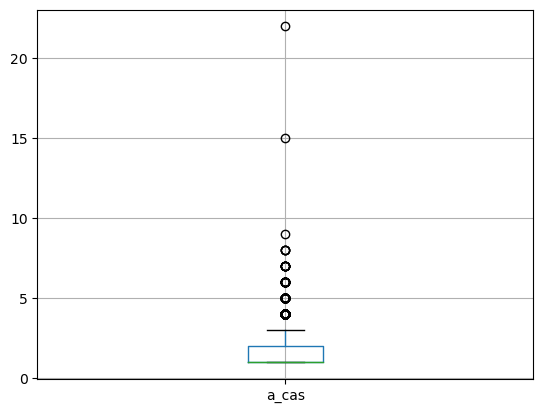

In [11]:
#boxplot of casuiltys
dfCol[['a_cas']].boxplot()

### As expected there are no Negative Casulties, but there is 2 dots that are outliers, at the 15 and 22/23(?) position <br>
### We will keep this data as knowing the location of the most serious/hightest casulty colisions is of high importance

### Maping values to decrease cognative Load
####  a_type: map 1,2,3 to Fatal,Serious,Slight

In [12]:
a_type_map = {
    1: "Fatal", 2: "Serious", 3: "Slight",
}

dfCol['a_type'] = dfCol['a_type'].replace(a_type_map)
dfCol.head(5)

a_year  a_ref a_District   a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD   Slight      1      1     SUN      1        1   
1    2017      2       MEAN   Slight      2      1     SUN      1        1   
2    2017      3       ARBC  Serious      1      1     SUN      1        1   
3    2017      4       ANTN   Slight      2      1     SUN      1        1   
4    2017      5       ANTN  Serious      2      2     SUN      1        1   

   a_hour  ...  a_jdet  a_jcont  a_pedhum  a_pedphys  a_light a_weat a_roadsc  \
0       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
1       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
2      10  ...       2        7         1          1        2     10        1   
3      10  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
4      11  ...       1        1         1          1        2      1        1   

  a_speccs a_chaz a_scene  
0      NaN    NaN     NaN  
1      NaN    NaN     NaN  
2        1      1       1  
3      NaN    NaN     NaN  
4        1      1       1  

[5 rows x 25 columns]

#### a_ctype: Map values from the data guide (Carriage way type)
#### a_jdet: Map values from the data guide (Junction Detail)
#### a_weat: Map values from the data guide (Weather Conditions)
#### a_light: Map values from the data guide (Light Conditions)

#### (data guide @ https://admin.opendatani.gov.uk/dataset/police-recorded-injury-road-traffic-collision-statistics-northern-ireland-2017/resource/de8384e7-95c8-4e35-910b-ce919db78024 )


In [13]:
a_ctype_map = {
    1: "Roundabout", 2: "One way street", 10: "Other / unknown",11:"Dual carriageway",12:"Motorway",13:"Single carriageway",14:"Slip road",
}
a_jdet_map = {
    '1': "Not at or within 20m of junction", '2': "Roundabout", '3': "Mini-roundabout",'6':"Crossroads",'8':"Multiple junction",'9':"Slip road",'10':"Private drive / entrance",'11':"Other junction",'12':"T or staggered junction"
}
a_weat_map = {
    '1': "Fine without high winds", '2': "Raining without high winds", '3': "Snowing without high winds",'4':"Fine with high winds",'5':"Raining with high winds",'6':"Snowing with high winds",'7':"Fog or mist - if hazard",'8':"Strong sun (glaring)",'9':'Other','10':"Unknown"
}
a_light_map = {
    '1': " Daylight: street lights present", '2': "Daylight: no street lighting", '3': "Daylight: street lighting unknown",'4':"Darkness: street lights present and lit",'5':"Darkness: street lights present but unlit",'6':"Darkness: no street lighting",'7':"Darkness: street lighting unknown",
}
dfCol['a_ctype'] = dfCol['a_ctype'].replace(a_ctype_map)
dfCol['a_jdet'] = dfCol['a_jdet'].replace(a_jdet_map)
dfCol['a_weat'] = dfCol['a_weat'].replace(a_weat_map)
dfCol['a_light'] = dfCol['a_light'].replace(a_light_map)
dfCol.head(5)

a_year  a_ref a_District   a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD   Slight      1      1     SUN      1        1   
1    2017      2       MEAN   Slight      2      1     SUN      1        1   
2    2017      3       ARBC  Serious      1      1     SUN      1        1   
3    2017      4       ANTN   Slight      2      1     SUN      1        1   
4    2017      5       ANTN  Serious      2      2     SUN      1        1   

   a_hour  ...                            a_jdet  a_jcont  a_pedhum a_pedphys  \
0       3  ...                               NaN      NaN       NaN       NaN   
1       3  ...                               NaN      NaN       NaN       NaN   
2      10  ...                        Roundabout        7         1         1   
3      10  ...                               NaN      NaN       NaN       NaN   
4      11  ...  Not at or within 20m of junction        1         1         1   

                        a_light                   a_weat a_roadsc a_speccs  \
0                           NaN                      NaN      NaN      NaN   
1                           NaN                      NaN      NaN      NaN   
2  Daylight: no street lighting                  Unknown        1        1   
3                           NaN                      NaN      NaN      NaN   
4  Daylight: no street lighting  Fine without high winds        1        1   

  a_chaz a_scene  
0    NaN     NaN  
1    NaN     NaN  
2      1       1  
3    NaN     NaN  
4      1       1  

[5 rows x 25 columns]

#### Make those rows catagorical

In [41]:
# Example: set some columns to categorical
for cat_col in ['a_type', 'a_ctype', 'a_jdet', 'a_weat','a_light']:
    if cat_col in dfCol.columns:
        dfCol[cat_col] = dfCol[cat_col].astype('category')
dfCol[['a_type', 'a_ctype', 'a_jdet', 'a_weat','a_light']].info() # It should be category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6081 entries, 0 to 6080
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   a_type   6081 non-null   category
 1   a_ctype  6081 non-null   category
 2   a_jdet   705 non-null    category
 3   a_weat   705 non-null    category
 4   a_light  705 non-null    category
dtypes: category(5)
memory usage: 31.2 KB


<H1>Vehicle Data</H1>
<h2>Reading and Cleaning</h2>

In [15]:
csv_path = 'vehicle2017.csv'

dfVeh = pd.read_csv(csv_path)

display(dfVeh.head(10))
print('Shape:', dfVeh.shape)
print('Columns:', list(dfVeh.columns))

a_year  a_ref  v_id  v_type  v_tow  v_man  v_loc v_junc v_skid v_hit  \
0    2017      1     1       8      1     18      3                       
1    2017      2     1       8      1     10      3                       
2    2017      2     2       8      1     18      3                       
3    2017      3     1       8      1     18      3      3      1     1   
4    2017      4     1       8      1     18      3                       
5    2017      4     2       8      1      2      3                       
6    2017      5     1       8      1     13      3      1      1     1   
7    2017      5     2       8      1      3      6      1      1     1   
8    2017      6     1       8      1      9      3                       
9    2017      6     2       8      1     13      3                       

  v_leave v_hitoff  v_impact v_sex v_agegroup  v_hitr v_forreg  
0                          2     1          6       1           
1                          3     1          7       1           
2                          2     1          6       2           
3       1        1         2     1          7       1        1  
4                          2     1          8       1           
5                          4                9       1           
6       1        1         2     1          5       1        1  
7       1        1         2     1          5       1        1  
8                          4     1          7       1           
9                          2     1          8       1

Shape: (11299, 17)
Columns: ['a_year', 'a_ref', 'v_id', 'v_type', 'v_tow', 'v_man', 'v_loc', 'v_junc', 'v_skid', 'v_hit', 'v_leave', 'v_hitoff', 'v_impact', 'v_sex', 'v_agegroup', 'v_hitr', 'v_forreg']


In [16]:
dfVeh.dtypes

a_year         int64
a_ref          int64
v_id           int64
v_type         int64
v_tow          int64
v_man          int64
v_loc          int64
v_junc        object
v_skid        object
v_hit         object
v_leave       object
v_hitoff      object
v_impact       int64
v_sex         object
v_agegroup    object
v_hitr         int64
v_forreg      object
dtype: object

### We already checked for duplicate collisions
### adding NaN
### Step 1: Quantify Missingness

In [17]:
# Define the values to consider as missing
missing_values = [' ','', 'Unknown', np.nan]

# Iterate through each column and count missing values
for col in dfVeh.columns:
    if col in ['a_District','a_wkday']: continue
    missing_count = dfVeh[col].isin(missing_values).sum() + dfVeh[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'v_junc': 10157 missing values
Column 'v_skid': 10157 missing values
Column 'v_hit': 10157 missing values
Column 'v_leave': 10157 missing values
Column 'v_hitoff': 10157 missing values
Column 'v_sex': 611 missing values
Column 'v_agegroup': 1 missing values
Column 'v_forreg': 10170 missing values


### 6 Columns are missing 10157 values (Nearly 90% of each of these columns is missing), this is substantial. There is also data missing from on sex of the driver and one instance of age of the driver<br>
### Step 2: replace missing with NaN

In [18]:
missing_values = [' ','', 'Unknown', np.nan]
dfVeh.replace(missing_values, np.nan, inplace=True)
dfVeh.head(10)

a_year  a_ref  v_id  v_type  v_tow  v_man  v_loc v_junc v_skid v_hit  \
0    2017      1     1       8      1     18      3    NaN    NaN   NaN   
1    2017      2     1       8      1     10      3    NaN    NaN   NaN   
2    2017      2     2       8      1     18      3    NaN    NaN   NaN   
3    2017      3     1       8      1     18      3      3      1     1   
4    2017      4     1       8      1     18      3    NaN    NaN   NaN   
5    2017      4     2       8      1      2      3    NaN    NaN   NaN   
6    2017      5     1       8      1     13      3      1      1     1   
7    2017      5     2       8      1      3      6      1      1     1   
8    2017      6     1       8      1      9      3    NaN    NaN   NaN   
9    2017      6     2       8      1     13      3    NaN    NaN   NaN   

  v_leave v_hitoff  v_impact v_sex v_agegroup  v_hitr v_forreg  
0     NaN      NaN         2     1          6       1      NaN  
1     NaN      NaN         3     1          7       1      NaN  
2     NaN      NaN         2     1          6       2      NaN  
3       1        1         2     1          7       1        1  
4     NaN      NaN         2     1          8       1      NaN  
5     NaN      NaN         4   NaN          9       1      NaN  
6       1        1         2     1          5       1        1  
7       1        1         2     1          5       1        1  
8     NaN      NaN         4     1          7       1      NaN  
9     NaN      NaN         2     1          8       1      NaN

### Maping values to decrease cognative Load
#### v_type: map 1,2...25 to Unknown,Pedal cycle...Agricultural vehicle
#### v_man: Map values from the data guide (Vehicle Manoeuvre)
#### v_impact: Map values from the data guide (First point of impact)
#### v_sex: Map values from the data guide (Sex of Driver)
#### v_agegroup: Map values from the data guide (Age of Driver)

#### (data guide @ https://admin.opendatani.gov.uk/dataset/police-recorded-injury-road-traffic-collision-statistics-northern-ireland-2017/resource/de8384e7-95c8-4e35-910b-ce919db78024 )


In [40]:
## Yeah Baby, I'm bACK and I'm clearing up the code I left in a HOT MESS last night (LET ME SLEEP) PLS GIVE EXSTENTION 

v_type_map = {
    0: "Unknown", 1: "Pedal cycle",2:"Motorcycle - moped",4:"Motorcycle (under 125cc)", 5:"Motorcycle (125cc and above)",6:'Invalid vehicle / other 3 wheeler',7:"Car - taxi (hackney)",8:"Car",9:"Motor caravan", 14:"Other motor vehicle",15: "Goods 3.5 tonnes or less",16:"Goods exceeding 3.5 tonnes but less than 7.5 tonnes",17:"Goods 7.5 tonnes or over",18:"Car (used as taxi)",19:"Minibus (8-16 passengers)",20:"Bus or coach (17+ passengers)",21:"Ridden horse",22:"Other non motor vehicle",23:"Motorcycle (engine size unknown)",24:"Goods vehicle (gross weight unknown)",25:"Agricultural vehicle"
}
v_man_map = {
    1: "Reversing", 2: "Parked", 3: "About to go ahead - held up",4:"Slowing / stopping",5:"Moving off",6:"U-turn",7:"Turning left",8:"Waiting to turn left",9:"Turning right",10:"Waiting to turn right",11:"Changing lane to left",12:"Changing lane to right",13:"Overtaking moving vehicle on offside",14:"Overtaking stationary vehicle on offside",15:"Overtaking on nearside",16:"Going ahead left-hand bend",17:"Going ahead right-hand bend",18:"Going ahead other",19:"Other / not known"
}
v_impact_map = {
    1: "Did not impact", 2: "Front", 3: "Back",4:"Offside",5:"Nearside"
}
v_sex_map = {
    '1': "Male", '2': "Female", '3': "Unknown"
}
v_agegroup_map = {
    '1':"Under 10",'2':"10-16",'3':"17-24","4":"25-34","5":"35-44",'6':"45-54","7":"55-64","8":"65+","9":"Unknown"
}
dfVeh['v_type'] = dfVeh['v_type'].replace(v_type_map)
dfVeh['v_man'] = dfVeh['v_man'].replace(v_man_map)
dfVeh['v_impact'] = dfVeh['v_impact'].replace(v_impact_map)
dfVeh['v_sex'] = dfVeh['v_sex'].replace(v_sex_map)
dfVeh['v_agegroup'] = dfVeh['v_agegroup'].replace(v_agegroup_map)
dfVeh.head(5)

a_year  a_ref  v_id v_type  v_tow                  v_man  v_loc v_junc  \
0    2017      1     1    Car      1      Going ahead other      3    NaN   
1    2017      2     1    Car      1  Waiting to turn right      3    NaN   
2    2017      2     2    Car      1      Going ahead other      3    NaN   
3    2017      3     1    Car      1      Going ahead other      3      3   
4    2017      4     1    Car      1      Going ahead other      3    NaN   

  v_skid v_hit v_leave v_hitoff v_impact v_sex v_agegroup  v_hitr v_forreg  \
0    NaN   NaN     NaN      NaN    Front  Male      45-54       1      NaN   
1    NaN   NaN     NaN      NaN     Back  Male      55-64       1      NaN   
2    NaN   NaN     NaN      NaN    Front  Male      45-54       2      NaN   
3      1     1       1        1    Front  Male      55-64       1        1   
4    NaN   NaN     NaN      NaN    Front  Male        65+       1      NaN   

   v_man_map  
0         18  
1         10  
2         18  
3         18  
4         18

#### Make those rows catagorical

In [42]:
# Example: set some columns to categorical
for cat_col in ['v_type', 'v_man', 'v_impact', 'v_sex','v_agegroup']:
    if cat_col in dfVeh.columns:
        dfVeh[cat_col] = dfVeh[cat_col].astype('category')
dfVeh[['v_type', 'v_man', 'v_impact', 'v_sex','v_agegroup']].info() # It should be category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11299 entries, 0 to 11298
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   v_type      11299 non-null  category
 1   v_man       11299 non-null  category
 2   v_impact    11299 non-null  category
 3   v_sex       10688 non-null  category
 4   v_agegroup  11298 non-null  category
dtypes: category(5)
memory usage: 57.4 KB


<H1>Casualty Data</H1>
<h2>Reading and Cleaning</h2>

In [44]:
csv_path = 'casualty2017.csv'

dfCas = pd.read_csv(csv_path)

display(dfCas.head(10))
print('Shape:', dfCas.shape)
print('Columns:', list(dfCas.columns))

a_year  a_ref  v_id  c_id  c_class  c_sex  c_agegroup  c_sever c_loc  \
0    2017      1     1     1        1      1           6        3         
1    2017      2     1     1        1      1           7        3         
2    2017      3     0     1        5      1           8        2     6   
3    2017      4     1     1        1      1           8        3         
4    2017      5     1     1        1      1           5        2     1   
5    2017      5     2     2        1      1           5        2     1   
6    2017      6     1     1        1      1           7        3         
7    2017      6     1     2        4      2           5        3         
8    2017      6     2     3        1      1           8        3         
9    2017      6     2     4        3      2           7        3         

  c_move  c_school c_pcv c_pedinj c_vtype  
0                8                      8  
1                8                      8  
2      6         8     1        2          
3                8                      8  
4      1         8     1                8  
5      1         8     1                8  
6                8                      8  
7                8                      8  
8                8                      8  
9                8                      8

Shape: (9184, 14)
Columns: ['a_year', 'a_ref', 'v_id', 'c_id', 'c_class', 'c_sex', 'c_agegroup', 'c_sever', 'c_loc', 'c_move', 'c_school', 'c_pcv', 'c_pedinj', 'c_vtype']


In [45]:
dfVeh.dtypes

a_year           int64
a_ref            int64
v_id             int64
v_type        category
v_tow            int64
v_man         category
v_loc            int64
v_junc          object
v_skid          object
v_hit           object
v_leave         object
v_hitoff        object
v_impact      category
v_sex         category
v_agegroup    category
v_hitr           int64
v_forreg        object
v_man_map        int64
dtype: object

### adding NaN
### Step 1: Quantify Missingness

In [46]:
# Define the values to consider as missing
missing_values = [' ','', 'Unknown', np.nan]

# Iterate through each column and count missing values
for col in dfCas.columns:
    if col in ['a_District','a_wkday']: continue
    missing_count = dfCas[col].isin(missing_values).sum() + dfCas[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'c_loc': 7951 missing values
Column 'c_move': 7951 missing values
Column 'c_pcv': 7951 missing values
Column 'c_pedinj': 8923 missing values
Column 'c_vtype': 729 missing values


### 5 Columns are missing values (Over 97% of Pedestrain Injuries On the Road Work is missing, with 3 Coluns missing (with rounding) 87%). 
### Step 2: replace missing with NaN

In [49]:
missing_values = [' ','', 'Unknown', np.nan]
dfCas.replace(missing_values, np.nan, inplace=True)
dfCas.head(10)

a_year  a_ref  v_id  c_id  c_class  c_sex  c_agegroup  c_sever c_loc  \
0    2017      1     1     1        1      1           6        3   NaN   
1    2017      2     1     1        1      1           7        3   NaN   
2    2017      3     0     1        5      1           8        2     6   
3    2017      4     1     1        1      1           8        3   NaN   
4    2017      5     1     1        1      1           5        2     1   
5    2017      5     2     2        1      1           5        2     1   
6    2017      6     1     1        1      1           7        3   NaN   
7    2017      6     1     2        4      2           5        3   NaN   
8    2017      6     2     3        1      1           8        3   NaN   
9    2017      6     2     4        3      2           7        3   NaN   

  c_move  c_school c_pcv c_pedinj c_vtype  
0    NaN         8   NaN      NaN       8  
1    NaN         8   NaN      NaN       8  
2      6         8     1        2     NaN  
3    NaN         8   NaN      NaN       8  
4      1         8     1      NaN       8  
5      1         8     1      NaN       8  
6    NaN         8   NaN      NaN       8  
7    NaN         8   NaN      NaN       8  
8    NaN         8   NaN      NaN       8  
9    NaN         8   NaN      NaN       8

### Maping values to decrease cognative Load
#### c_class: map 1,2...7 to Driver, Pillion passenger...Pedal cyclist
#### c_sex: Map values from the data guide (Sex of Casualty)
#### c_agegroup: Map values from the data guide (Age of Casualty)
#### c_sever: Map values from the data guide (Severity of Casualty)
#### c_pcv: Map values from the data guide (Bus or Coach Passenger)
#### c_vtype: Map values from the data guide (Casualty Vehicle Type)

#### (data guide @ https://admin.opendatani.gov.uk/dataset/police-recorded-injury-road-traffic-collision-statistics-northern-ireland-2017/resource/de8384e7-95c8-4e35-910b-ce919db78024 )

In [58]:
c_class_map = {
    1: "Driver",2:"Pillion passenger",3:"Vehicle passenger - front",4:"Vehicle passenger - rear", 5:"Pedestrian",6:'Motorcyclist',7:"Pedal cyclist"
}
c_sex_map = {
    1: "Male", 2: "Female", 3: "Unknown"
}
c_agegroup_map = {
    1:"Under 10",2:"10-16",3:"17-24",4:"25-34",5:"35-44",6:"45-54",7:"55-64",8:"65+",9:"Unknown"
}
c_sever_map = {
    1: "Fatal", 2: "Serious", 3: "Slight",
}
c_pcv_map = {
    '1': "Not a bus or coach passenger", '2': "Boarding", '3': "Alighting",4:"Standing passenger",5:"Seated passenger"
}
c_vtype_map = {
    '1': "Pedal cycle",'2':"Motorcycle - moped",'4':"Motorcycle (under 125cc)", '5':"Motorcycle (125cc and above)",'6':'Invalid vehicle / other 3 wheeler','7':"Car - taxi (hackney)",'8':"Car",'9':"Motor caravan", '14':"Other motor vehicle",'15': "Goods 3.5 tonnes or less",'16':"Goods exceeding 3.5 tonnes but less than 7.5 tonnes",'17':"Goods 7.5 tonnes or over",'18':"Car (used as taxi)",'19':"Minibus (8-16 passengers)",'20':"Bus or coach (17+ passengers)",'21':"Ridden horse",'22':"Other non motor vehicle",'23':"Motorcycle (engine size unknown)",'24':"Goods vehicle (gross weight unknown)",'25':"Agricultural vehicle"
}
dfCas['c_class'] = dfCas['c_class'].replace(c_class_map)
dfCas['c_sex'] = dfCas['c_sex'].replace(c_sex_map)
dfCas['c_agegroup'] = dfCas['c_agegroup'].replace(c_agegroup_map)
dfCas['c_sever'] = dfCas['c_sever'].replace(c_sever_map)
dfCas['c_pcv'] = dfCas['c_pcv'].replace(c_pcv_map)
dfCas['c_vtype'] = dfCas['c_vtype'].replace(c_vtype_map)
dfCas.head(5)

a_year  a_ref  v_id  c_id     c_class c_sex c_agegroup  c_sever c_loc  \
0    2017      1     1     1      Driver  Male      45-54   Slight   NaN   
1    2017      2     1     1      Driver  Male      55-64   Slight   NaN   
2    2017      3     0     1  Pedestrian  Male        65+  Serious     6   
3    2017      4     1     1      Driver  Male        65+   Slight   NaN   
4    2017      5     1     1      Driver  Male      35-44  Serious     1   

  c_move  c_school                         c_pcv c_pedinj c_vtype  
0    NaN         8                           NaN      NaN     Car  
1    NaN         8                           NaN      NaN     Car  
2      6         8  Not a bus or coach passenger        2     NaN  
3    NaN         8                           NaN      NaN     Car  
4      1         8  Not a bus or coach passenger      NaN     Car

In [60]:
# Example: set some columns to categorical
for cat_col in ['c_class', 'c_sex', 'c_pcv','c_vtype', 'c_sever','c_agegroup']:
    if cat_col in dfCas.columns:
        dfCas[cat_col] = dfCas[cat_col].astype('category')
dfCas[['c_class', 'c_sex', 'c_pcv','c_vtype', 'c_sever','c_agegroup']].info() # It should be category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9184 entries, 0 to 9183
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   c_class     9184 non-null   category
 1   c_sex       9184 non-null   category
 2   c_pcv       1233 non-null   category
 3   c_vtype     8455 non-null   category
 4   c_sever     9184 non-null   category
 5   c_agegroup  9184 non-null   category
dtypes: category(6)
memory usage: 55.8 KB


<H1>EDA</H1>

In [62]:
# this needs to be fixed
dfCol.describe()


a_year        a_ref        a_veh        a_cas        a_day  \
count  6081.0  6081.000000  6081.000000  6081.000000  6081.000000   
mean   2017.0  3041.000000     1.858083     1.510278    15.637066   
std       0.0  1755.577825     0.635119     0.987888     8.780679   
min    2017.0     1.000000     1.000000     1.000000     1.000000   
25%    2017.0  1521.000000     1.000000     1.000000     8.000000   
50%    2017.0  3041.000000     2.000000     1.000000    16.000000   
75%    2017.0  4561.000000     2.000000     2.000000    23.000000   
max    2017.0  6081.000000     8.000000    22.000000    31.000000   

           a_month       a_hour        a_min          a_gd1          a_gd2  \
count  6081.000000  6081.000000  6081.000000    6081.000000    6081.000000   
mean      6.703009    13.791646    27.897714  310065.191745  375149.076303   
std       3.452060     4.942282    17.656101   33968.228173   25897.472816   
min       1.000000     0.000000     0.000000  193839.000000  311277.000000   
25%       4.000000    10.000000    14.000000  290929.000000  360875.000000   
50%       7.000000    14.000000    30.000000  323831.000000  373885.000000   
75%      10.000000    17.000000    44.000000  334198.000000  386271.000000   
max      12.000000    23.000000    59.000000  365563.000000  444002.000000   

           a_speed  
count  6081.000000  
mean     43.146686  
std      14.741820  
min      10.000000  
25%      30.000000  
50%      30.000000  
75%      60.000000  
max      70.000000

ValueError: boxplot method requires numerical columns, nothing to plot.

In [65]:
# Create a transformer from Irish Grid (EPSG:29903) to WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:29903", "EPSG:4326", always_xy=True)

# Convert Easting/Northing to Longitude/Latitude
# The transformer returns (longitude, latitude)
dfCol['longitude'], dfCol['latitude'] = transformer.transform(
    dfCol['a_gd1'].values,
    dfCol['a_gd2'].values
)

# View the results
print(dfCol[['a_gd1', 'a_gd2', 'longitude', 'latitude']].head(10))

    a_gd1   a_gd2  longitude   latitude
0  339189  339097  -5.863640  54.281742
1  305164  401602  -6.363452  54.851131
2  288498  345801  -6.639651  54.353228
3  334975  380862  -5.909253  54.657811
4  313692  389836  -6.235357  54.743628
5  353373  375446  -5.627257  54.603946
6  327818  363612  -6.027577  54.504807
7  321640  399559  -6.107941  54.829062
8  267513  409174  -6.947728  54.925622
9  311983  396730  -6.259224  54.805910


In [66]:
print(dfCol['a_District'].value_counts())

a_District
BELC    1478
ARBC     601
NEMD     574
LISC     525
ANTN     471
DCST     449
MIDU     436
ARND     430
CCGL     407
MEAN     390
FERO     320
Name: count, dtype: int64


In [74]:
import folium

# Create a map centered around the approximate center of Northern Ireland
map_center_lat = dfCol['latitude'].mean()
map_center_lon = dfCol['longitude'].mean()

m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=8) # Increased zoom for Northern Ireland

# Add a sample of points to the map
for _, row in dfCol.sample(min(6081, len(dfCol)), random_state=42).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

# Display the map
display(m)